# Training and cross validation of Cosolvent GPR model

This workbook performs leave-one-out cross validation to evaulate the goodness-of-fit for the Gaussian processes regression model trained to predict ternary compositions from measured electriolyte physicochemical properties.

In [1]:
# import packages
import os, sys, platform
import numpy as np
import pandas as pd
import GPy
import matplotlib.pyplot as plt
from matplotlib import gridspec
import warnings
warnings.filterwarnings('ignore')

print('Python version', sys.version)
print('Running on', platform.system())

# colours (From Birmingham With Love)
jade = np.array([0, .66, .436]) # statue green
blue = np.array([.057, .156, .520]) # hey there mr blue
brown = np.array([.515, .158, .033]) # did someone order CDM?
red = np.array([.85, .20, 0]) # tikka masala
gold = np.array([1, .67, .14]) # Staffordshire hoard
claret = np.array([.429, .073, .238]) # claret
grey = np.array([.585, .612, .675]) # library grey
black = np.array([0,0,0]) # this is a black

Python version 3.7.6 (default, Jan  8 2020, 13:42:34) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
Running on Darwin


---
### Defining functions

In [7]:
#General GPy function
#=========================================
def gpy_func(X, y):
    """
    Function performs the GP regression. 
    The inputs X and y are the input and output pairs.
    """
    n = X.shape[0] # number of data points
    d = X.shape[1] # dimension of input
    
    # build kernel
    k_rbf = GPy.kern.RBF(input_dim=d,
                         ARD=True,
                         lengthscale=X.std(axis=0),
                         variance=y.var()/2)

    kernel = k_rbf
    
    # priors
    prior_uniform = GPy.priors.Uniform(0,1000)
    prior_gamma = GPy.priors.Gamma(a=1,b=1)
    
    # likelihood
    lik = GPy.likelihoods.Gaussian()
    
    # initially construct the model
    gpm = GPy.core.GP(    X=X, 
                          Y=y,
                          likelihood=lik,
                          kernel=kernel)
    
    # set priors
    for j in range(X.shape[1]):
        gpm.kern.lengthscale[[j]].set_prior(prior_uniform, warning=False)
        gpm.kern.lengthscale[[j]] = X[:,j].std()*(2**.5) # start within the prior
    
    gpm.kern.variance.set_prior(prior_gamma, warning=False)
    gpm.likelihood.variance.set_prior(prior_gamma, warning=False)
    
    # optimize the hyperparameters
    for i in range(0,20): # OPTIMIZE 10x,20x?
        gpm.optimize()
    
    return gpm

---
### Load and organise training CSV data

In [8]:
training_file = 'trainingset/Ternary_Physicochemical_Training.csv'

# Load training data
F = pd.read_csv(training_file)

df = F.sort_values(["xEC", "xLiPF6", "Temp"], ascending = (False, False, True)) #Groups same composition properties together in ascending temperatures
data = df.to_numpy()
properties = data[:,5:]
compositions = data[:,[2,4]] #Change to 2,4 for just LiPF6 and EMC independent compositions, infer EC later
properties = np.array(np.split(properties,np.arange(5,len(data),5))) #Subarray every 5 temps
compositions = np.array(np.split(compositions,np.arange(5,len(data),5))) #Subarray every 5 temps

properties = np.array([i.flatten() for i in properties]) #properties are d,v,k for 10,20,25,30,40 C in that order
compositions = np.array([np.mean(i,0) for i in compositions])  #compositions are x_LiPF6, x_EMC

---
### Checking the ternary predictions sum to unity

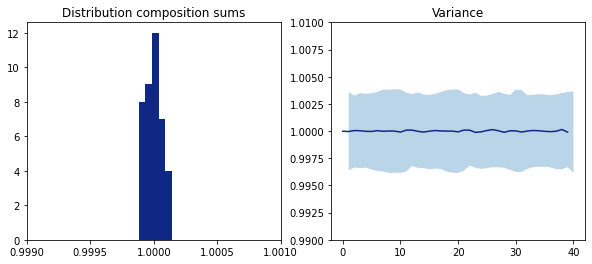

In [9]:
#Checking if the sum of variables predictions add up to 1
#============================================
all_compositions = data[:,2:5] #Change to 2,4 for just LiPF6 and EMC independent compositions, infer EC later
all_compositions = np.array(np.split(all_compositions,np.arange(5,len(data),5))) #Subarray every 5 temps
all_compositions = np.array([np.mean(i,0) for i in all_compositions])

Y = all_compositions
X = properties

n = X.shape[0] #number of rows of data
d = X.shape[1] #dimensions of each data point

#Training
gpm_comp = gpy_func(X,Y)
y, var = gpm_comp.predict(X)
pred_sum = np.array([sum(i) for i in y])
pred_2σ = np.sqrt(np.array([sum(i) for i in var]))

# plotting
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].set_title('Distribution composition sums')
ax[0].hist(pred_sum,5,color=blue)
ax[0].set_xlim(1+.001*np.array([-1, 1]))
ax[0].xaxis.set_major_locator(plt.MaxNLocator(4)) #4 bins
# variance investigation
ax[1].set_title('Variance')
ax[1].fill_between(np.linspace(1,n,n),pred_sum+pred_2σ,pred_sum-pred_2σ,\
                  alpha=.3)
ax[1].plot(pred_sum,color=blue)
ax[1].set_ylim(1+.01*np.array([-1, 1]));

---
### Cross validation with leave-one-out method

In [32]:
# Performing the Leave-one-out cross validation loop
Y = compositions
X = properties

n = X.shape[0] #number of rows of data
d = X.shape[1] #dimensions of each data point

x = X
y = Y
n = X.shape[0]
d = X.shape[1]
K = n #LOOCV

indices = np.random.permutation(x.shape[0])
split_indx = np.floor(np.linspace(0,x.shape[0],K+1)).astype(int)

Ntest = []
Ntrain = []
for j in range(K):
    Ntest.append(indices[split_indx[j]:split_indx[j+1]])
    Ntrain.append(np.hstack((indices[:split_indx[j]],indices[split_indx[j+1]:])))

# train model
results = np.hstack((np.array(range(n)).reshape((n,1)),np.zeros((n,2))))
Params = [np.zeros((0,d+2)),np.zeros((0,d+2)),np.zeros((0,d+2))]

y_pred = np.empty(y.shape[1])
var_pred = np.empty(1)
y_true = np.empty(y.shape[1])

for j in range(K):
    x_j = x[Ntrain[j],:]
    y_j = y[Ntrain[j],:]
    x_test = x[Ntest[j],:]
    y_true_j = y[Ntest[j],:]
    
    gpm = gpy_func(x_j,y_j)
    
    y_pred_j, var_pred_j = gpm.predict(x_test)
    
    y_pred = np.vstack([y_pred,y_pred_j])
    var_pred = np.vstack([var_pred,var_pred_j])
    y_true = np.vstack([y_true,y_true_j])
    
    print('k = '+str(j+1)+' of '+str(K))
    
#Summarizing cross validation results
#===============================================
rmse = np.sqrt(((y_pred - y_true)**2))
std_pred = np.sqrt(var_pred)
# pred_sum = np.array([np.array(sum(i)) for i in y_pred]).reshape(len(rmse),1)
true_EC = np.array([1-np.sum(i) for i in y_true]).reshape(len(rmse),1)
pred_EC = np.array([1-np.sum(i) for i in y_pred]).reshape(len(rmse),1)
all_data = np.hstack((y_true,true_EC,y_pred,pred_EC,rmse,var_pred,std_pred))

df = pd.DataFrame(data=all_data,
              columns=['true_LiPF6','true_EMC','true_EC','pred_LiPF6','pred_EMC','pred_EC',
                      'rmse_LiPF6','rmse_EMC','v','sd'])

df = df.iloc[1: , :]
df.to_csv('results/LOOCV_DF.csv',index=False)

k = 1 of 40
k = 2 of 40
k = 3 of 40
k = 4 of 40
k = 5 of 40
k = 6 of 40
k = 7 of 40
k = 8 of 40
k = 9 of 40
k = 10 of 40
k = 11 of 40
k = 12 of 40
k = 13 of 40
k = 14 of 40
k = 15 of 40
k = 16 of 40
k = 17 of 40
k = 18 of 40
k = 19 of 40
k = 20 of 40
k = 21 of 40
k = 22 of 40
k = 23 of 40
k = 24 of 40
k = 25 of 40
k = 26 of 40
k = 27 of 40
k = 28 of 40
k = 29 of 40
k = 30 of 40
k = 31 of 40
k = 32 of 40
k = 33 of 40
k = 34 of 40
k = 35 of 40
k = 36 of 40
k = 37 of 40
k = 38 of 40
k = 39 of 40
k = 40 of 40


---
### Visualising the variance around predicted and true electrolyte ternary compositions

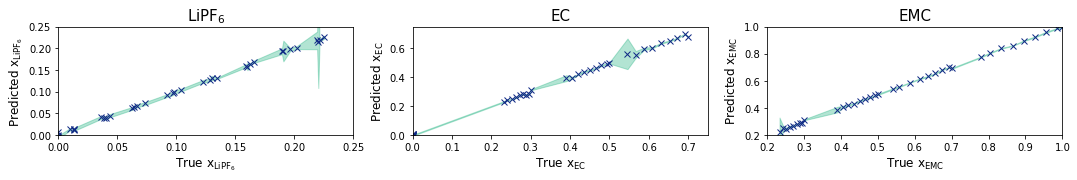

In [23]:
df = pd.read_csv ('results/LOOCV_DF.csv')

#Across entire training dataset range
#===============================================
df = df[df.true_LiPF6<0.23]

fig, ax = plt.subplots(1,3,figsize=(18,2))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

# LiPF6
df = df.sort_values(by=['true_LiPF6'])
ax[0].set_title('$LiPF_6$',fontsize = 15)
ax[0].plot(df.true_LiPF6,df.pred_LiPF6,'x',color=blue)
ax[0].fill_between(df.true_LiPF6,df.pred_LiPF6+df.sd,df.pred_LiPF6-df.sd,\
                   color=jade,alpha=.3)
ax[0].set_xlim([0,0.25])
ax[0].set_ylim([0,0.25])
ax[0].set_ylabel('Predicted $x_{LiPF_6}$', fontsize=12)
ax[0].set_xlabel('True $x_{LiPF_6}$', fontsize=12)

# EC
df = df.sort_values(by=['true_EC'])
ax[1].set_title('EC',fontsize = 15)
ax[1].plot(df.true_EC,df.pred_EC,'x',color=blue)
ax[1].fill_between(df.true_EC,df.pred_EC+df.sd,df.pred_EC-df.sd,\
                   color=jade,alpha=.3)
ax[1].set_xlim([0,0.75])
ax[1].set_ylim([0,0.75])
ax[1].set_ylabel('Predicted $x_{EC}$', fontsize=12)
ax[1].set_xlabel('True $x_{EC}$', fontsize=12)

# EMC
df = df.sort_values(by=['true_EMC'])
ax[2].set_title('EMC',fontsize = 15)
ax[2].plot(df.true_EMC,df.pred_EMC,'x',color=blue)
ax[2].fill_between(df.true_EMC,df.pred_EMC+df.sd,df.pred_EMC-df.sd,\
                   color=jade,alpha=.3)
ax[2].set_xlim([0.2,1])
ax[2].set_ylim([0.2,1])
ax[2].set_ylabel('Predicted $x_{EMC}$', fontsize=12)
ax[2].set_xlabel('True $x_{EMC}$', fontsize=12)

plt.show()

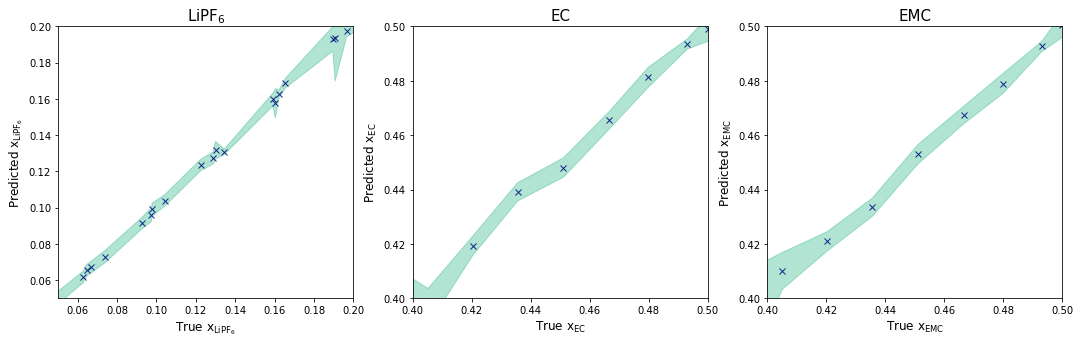

In [24]:
df = pd.read_csv ('results/LOOCV_DF.csv')

#Within the Hittorf experimental range
#===============================================
df = df[df.true_LiPF6<0.23]

fig, ax = plt.subplots(1,3,figsize=(18,5))
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

# LiPF6
df = df.sort_values(by=['true_LiPF6'])
ax[0].set_title('$LiPF_6$',fontsize = 15)
ax[0].plot(df.true_LiPF6,df.pred_LiPF6,'x',color=blue)
ax[0].fill_between(df.true_LiPF6,df.pred_LiPF6+df.sd,df.pred_LiPF6-df.sd,\
                   color=jade,alpha=.3)
ax[0].set_xlim([0.05,0.2])
ax[0].set_ylim([0.05,0.2])
ax[0].set_ylabel('Predicted $x_{LiPF_6}$', fontsize=12)
ax[0].set_xlabel('True $x_{LiPF_6}$', fontsize=12)



# EC
df = df.sort_values(by=['true_EC'])
ax[1].set_title('EC',fontsize = 15)
ax[1].plot(df.true_EC,df.pred_EC,'x',color=blue)
ax[1].fill_between(df.true_EC,df.pred_EC+df.sd,df.pred_EC-df.sd,\
                   color=jade,alpha=.3)
ax[1].set_xlim([0.4,0.5])
ax[1].set_ylim([0.4,0.5])
ax[1].set_ylabel('Predicted $x_{EC}$', fontsize=12)
ax[1].set_xlabel('True $x_{EC}$', fontsize=12)


# EMC
df = df.sort_values(by=['true_EMC'])
ax[2].set_title('EMC',fontsize = 15)
ax[2].plot(df.true_EMC,df.pred_EMC,'x',color=blue)
ax[2].fill_between(df.true_EMC,df.pred_EMC+df.sd,df.pred_EMC-df.sd,\
                   color=jade,alpha=.3)
ax[2].set_xlim([0.4,0.5])
ax[2].set_ylim([0.4,0.5])
ax[2].set_ylabel('Predicted $x_{EMC}$', fontsize=12)
ax[2].set_xlabel('True $x_{EMC}$', fontsize=12)

plt.show()

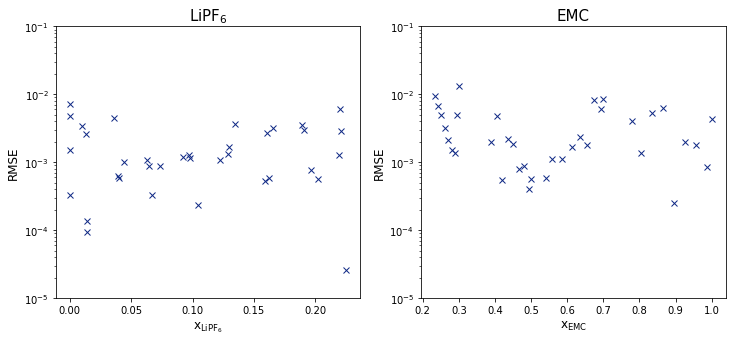

In [25]:
#RMSE, predicting LiPF6 and EMC only, and inferring EC
#===============================================
scale_variable = 'log'

fig, ax = plt.subplots(1,2,figsize=(12,5))

# LiPF6
ax[0].set_title('$LiPF_6$',fontsize = 15)
ax[0].plot(df.true_LiPF6,df.rmse_LiPF6,'x',color=blue)
ax[0].set_yscale(scale_variable)
ax[0].set_ylim([1E-5,0.1])
ax[0].set_ylabel('RMSE', fontsize=12)
ax[0].set_xlabel('$x_{LiPF_6}$', fontsize=12)
# EMC
ax[1].set_title('EMC',fontsize = 15)
ax[1].plot(df.true_EMC,df.rmse_EMC,'x',color=blue)
ax[1].set_yscale(scale_variable)
ax[1].set_ylabel('RMSE', fontsize=12)
ax[1].set_xlabel('$x_{EMC}$', fontsize=12)
ax[1].set_ylim([1E-5,0.1])

mean_rmse = np.mean(df[['rmse_LiPF6','rmse_EMC']].to_numpy().flatten())
std_rmse = np.std(df[['rmse_LiPF6','rmse_EMC']].to_numpy().flatten())

plt.show()

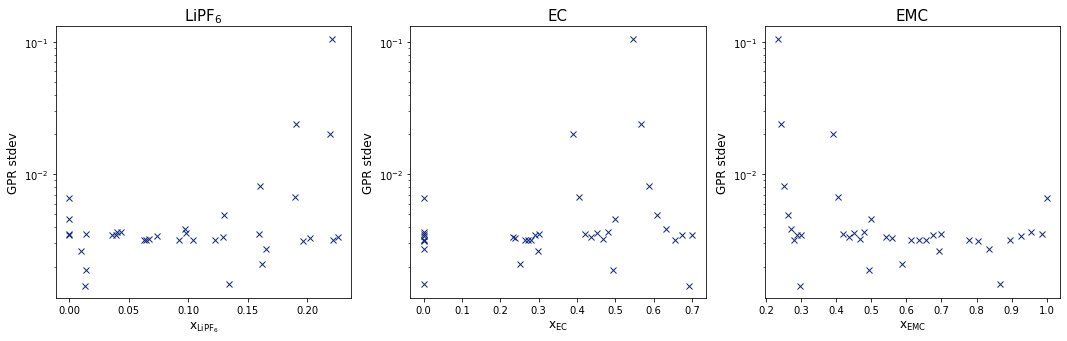

In [26]:
#GPR Standard deviation
#===============================================
scale_variable = 'log'

fig, ax = plt.subplots(1,3,figsize=(18,5))

# LiPF6
ax[0].set_title('$LiPF_6$',fontsize = 15)
ax[0].plot(df.true_LiPF6,df.sd,'x',color=blue)
ax[0].set_yscale(scale_variable)
ax[0].set_ylabel('GPR stdev', fontsize=12)
ax[0].set_xlabel('$x_{LiPF_6}$', fontsize=12)
# EC
ax[1].set_title('EC',fontsize = 15)
ax[1].plot(df.true_EC,df.sd,'x',color=blue)
ax[1].set_yscale(scale_variable)
ax[1].set_ylabel('GPR stdev', fontsize=12)
ax[1].set_xlabel('$x_{EC}$', fontsize=12)

# EMC
ax[2].set_title('EMC',fontsize = 15)
ax[2].plot(df.true_EMC,df.sd,'x',color=blue)
ax[2].set_yscale(scale_variable)
ax[2].set_ylabel('GPR stdev', fontsize=12)
ax[2].set_xlabel('$x_{EMC}$', fontsize=12)

plt.show()